In [1781]:
import os
import csv
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import bootstrap
import glob
from tqdm import tqdm
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.feature_selection import RFECV
from sklearn.metrics import confusion_matrix, roc_curve, auc
import statsmodels.api as sm
from sklearn.utils import resample
import re

import warnings
warnings.filterwarnings("ignore")

from sklearn.naive_bayes import GaussianNB, MultinomialNB

In [1782]:
# removing extra comma in cycling dataset9.csv and cycling dataset14.csv manually as suggested on piazza
# bending2 dataset4.csv space separated (delimitter/sep_)
# https://www.geeksforgeeks.org/how-to-use-glob-function-to-find-files-recursively-in-python/
path = '../../data/AReM/'
actv_dir = ['bending1', 'bending2']
actv_dir2 = ['bending1','bending2','cycling', 'lying', 'sitting', 'standing', 'walking']
features = ['mean_', 'std_', 'min_', 'first_quartile_', 'median_', 'third_quartile_','max_']
columns = ['# Columns: time', 'avg_rss12', 'var_rss12', 'avg_rss13', 'var_rss13', 'avg_rss23', 'var_rss23']




In [1783]:


def train_test_data():
    train_set = []
    test_set = []
    all_set = []
    # scanning bottom-to-up
    for root, dirs, files in os.walk(path, topdown=False):
        for name in files:
            # Split the path in root and ext pair
            root_ext = os.path.splitext(name)
            # checking the extension
            root_val = root_ext[1]
            if root_val.endswith('.csv'):
                # https://www.geeksforgeeks.org/python-regex-re-search-vs-re-findall/
                file_path = os.path.join(root+ '/' +name)
                # print(file_path)
                # print(file_path)
                my_path = os.path.split(root)
                feature_act = my_path[-1] #to get just the activity name
                # my_path = Path(path)
                # activity = my_path.stem
                regex = '\d+'
                match = re.findall(regex, name)
                # for bending 1 and 2 and dataset 1,2 and 3
                # https://docs.python.org/3/library/stdtypes.html#str.find
                match_activity = int(match[0])
                bool1 = name.find('dataset1.csv')!= -1
                bool2 = name.find('dataset2.csv')!=-1
                bool3 = name.find('dataset3.csv')!=-1
                
                if root.find('bending') != -1:
                    if (bool1 or bool2):
                        test_set.append(file_path)
                        all_set.append(file_path)
                    else:
                        train_set.append(file_path)
                        all_set.append(file_path)
                # dataset 1,2 and 3
                    # bool2 = match_activity == 3 and feature_act not in actv_dir
                else:
                    if (bool1 or bool2 or bool3):
                        test_set.append(file_path)
                        all_set.append(file_path)
                    else:
                        train_set.append(file_path)
                        all_set.append(file_path)
    return train_set, test_set, all_set
train_set, test_set, all_set = train_test_data()

In [1784]:
train_set

['../../data/AReM/bending1/dataset7.csv',
 '../../data/AReM/bending1/dataset6.csv',
 '../../data/AReM/bending1/dataset4.csv',
 '../../data/AReM/bending1/dataset5.csv',
 '../../data/AReM/bending1/dataset3.csv',
 '../../data/AReM/walking/dataset7.csv',
 '../../data/AReM/walking/dataset6.csv',
 '../../data/AReM/walking/dataset4.csv',
 '../../data/AReM/walking/dataset5.csv',
 '../../data/AReM/walking/dataset10.csv',
 '../../data/AReM/walking/dataset11.csv',
 '../../data/AReM/walking/dataset13.csv',
 '../../data/AReM/walking/dataset12.csv',
 '../../data/AReM/walking/dataset15.csv',
 '../../data/AReM/walking/dataset14.csv',
 '../../data/AReM/walking/dataset8.csv',
 '../../data/AReM/walking/dataset9.csv',
 '../../data/AReM/bending2/dataset6.csv',
 '../../data/AReM/bending2/dataset4.csv',
 '../../data/AReM/bending2/dataset5.csv',
 '../../data/AReM/bending2/dataset3.csv',
 '../../data/AReM/standing/dataset7.csv',
 '../../data/AReM/standing/dataset6.csv',
 '../../data/AReM/standing/dataset4.csv'

In [1785]:
feature_names = ['min','max','mean','median','sd','first_quartile','third_quartile']
features = [name+str(i) for i in range(1,7) for name in feature_names]
features.append('activity')
column_names = ['# Columns: time', 'avg_rss12', 'var_rss12', 'avg_rss13', 'var_rss13', 'avg_rss23', 'var_rss23']

In [1786]:
# https://stackoverflow.com/questions/18366797/pandas-read-csv-how-to-skip-comment-lines
# https://stackoverflow.com/questions/25440008/python-pandas-flatten-a-dataframe-to-a-list

all_csv_files = glob.glob('../../data/AReM/*/*.csv', recursive=True)
# print(all_csv_files)
sniffer = csv.Sniffer()
def load_data(data, features, splits=1):
    sniffer = csv.Sniffer()
    all_data = pd.DataFrame(columns=features)
    
    for csv_files in data:
        
        # Get the delimiter in the CSV file
        root = os.path.dirname(csv_files)
        my_path = os.path.split(root)
        feat_act = my_path[-1]
        # print(feat_act)
        sep_ = sniffer.sniff(open(csv_files).readlines()[6])
        # sep_ = sniffer.sniff(open(csv).read())
        delimiter = sep_.delimiter
        if delimiter == ',':
            df = pd.read_csv(csv_files, sep = delimiter, comment = '#', header=None)
        else:
            df = pd.read_csv(csv_files, sep = delimiter, comment = '#', header=None)
            # print(df)
            df = df.drop([7], axis=1)
        df = df.drop([0], axis=1)
        # finding length of each split
        split_length = int(df.shape[0]/splits)
        train_test_seg = []
        for idx, col in enumerate(df.columns):
            for j in range(splits):
                data = df[j*split_length : min((j+1)*split_length,df.shape[0])]
                train_test_seg.extend([np.min(data[col]),np.max(data[col]),np.mean(data[col]),np.median(data[col]),
                            np.std(data[col]),np.percentile(data[col],25),np.percentile(data[col], 75)])
        train_test_seg.append(feat_act)   
        df_new = pd.Series(train_test_seg, index = features)
        all_data = all_data.append(df_new, ignore_index=True)
    return all_data

In [1787]:
new_columns = ['min_','max_','mean_','median_','std_','first_quartile_', 'third_quartile_']
activity = [stat + str(i) for i in range(1, 7) for stat in new_columns]
# train set
new_train_set = load_data(train_set, features)
print('')
print('Train set is: ')
print(new_train_set)
print('')
new_test_set = load_data(test_set, features)
print('Test set is: ')
# test_stats.isnull().any()
print(new_test_set)


Train set is: 
     min1   max1      mean1  median1       sd1  first_quartile1  \
0   36.25  48.00  43.969125    44.50  1.616677          43.3100   
1   37.00  48.00  43.454958    43.25  1.384653          42.5000   
2   33.00  47.75  42.179812    43.50  3.666840          39.1500   
3   33.00  45.75  41.678063    41.75  2.241152          41.3300   
4   35.00  47.40  43.954500    44.33  1.557210          43.0000   
..    ...    ...        ...      ...       ...              ...   
64  18.50  44.25  35.752354    36.00  4.609992          33.0000   
65  24.25  45.00  37.177042    36.25  3.577569          34.5000   
66  23.33  43.50  36.244083    36.75  3.818032          33.4575   
67  26.25  44.25  36.957458    36.29  3.431283          34.5000   
68  27.75  44.67  37.144833    36.33  3.754986          34.0000   

    third_quartile1  min2   max2     mean2  ...  first_quartile5  \
0             44.67   0.0   1.50  0.413125  ...          20.5000   
1             45.00   0.0   1.58  0.378083 

In [1788]:
new_all_set = load_data(all_set, features)
new_all_set

min1   max1      mean1  median1       sd1  first_quartile1  \
0   36.25  48.00  43.969125    44.50  1.616677          43.3100   
1   37.00  48.00  43.454958    43.25  1.384653          42.5000   
2   33.00  47.75  42.179812    43.50  3.666840          39.1500   
3   33.00  45.75  41.678063    41.75  2.241152          41.3300   
4   37.25  45.00  40.624792    40.50  1.475428          39.2500   
..    ...    ...        ...      ...       ...              ...   
83  18.50  44.25  35.752354    36.00  4.609992          33.0000   
84  24.25  45.00  37.177042    36.25  3.577569          34.5000   
85  23.33  43.50  36.244083    36.75  3.818032          33.4575   
86  26.25  44.25  36.957458    36.29  3.431283          34.5000   
87  27.75  44.67  37.144833    36.33  3.754986          34.0000   

    third_quartile1  min2   max2     mean2  ...  first_quartile5  \
0             44.67   0.0   1.50  0.413125  ...          20.5000   
1             45.00   0.0   1.58  0.378083  ...          22.2500   
2             45.00   0.0   3.00  0.696042  ...          30.4575   
3             42.75   0.0   2.83  0.535979  ...          28.4575   
4             42.00   0.0   1.30  0.358604  ...          33.0000   
..              ...   ...    ...       ...  ...              ...   
83            39.33   0.0  12.60  3.328104  ...          14.0000   
84            40.25   0.0   8.58  2.374208  ...          17.9500   
85            39.25   0.0   9.71  2.736021  ...          15.7500   
86            40.25   0.0   8.64  2.420083  ...          14.0000   
87            40.50   0.0  10.76  2.419062  ...          15.0000   

    third_quartile5  min6   max6     mean6  median6       sd6  \
0           23.7500   0.0   2.96  0.555312    0.490  0.487318   
1           24.0000   0.0   5.26  0.679646    0.500  0.621885   
2           36.3300   0.0   2.18  0.613521    0.500  0.523771   
3           31.2500   0.0   1.79  0.383292    0.430  0.388759   
4           36.0000   0.0   1.92  0.570583    0.430  0.582308   
..              ...   ...    ...       ...      ...       ...   
83          18.0625   0.0   9.39  3.069667    2.770  1.746503   
84          21.7500   0.0   9.34  2.921729    2.500  1.850669   
85          21.0000   0.0  11.15  3.530500    3.110  1.961639   
86          18.2500   0.0   8.34  2.934625    2.525  1.629680   
87          18.7500   0.0   8.75  2.822437    2.590  1.635476   

    first_quartile6  third_quartile6  activity  
0            0.0000           0.8300  bending1  
1            0.4300           0.8700  bending1  
2            0.0000           1.0000  bending1  
3            0.0000           0.5000  bending1  
4            0.0000           1.3000  bending1  
..              ...              ...       ...  
83           1.7975           4.0600   cycling  
84           1.5000           3.9000   cycling  
85           2.1700           4.6175   cycling  
86           1.6600           4.0300   cycling  
87           1.5800           3.7400   cycling  

[88 rows x 43 columns]

In [1789]:
print('Std:')
new_all_set.describe().loc['std']

Std:


min1               9.569975
max1               4.394362
mean1              5.335718
median1            5.440054
sd1                1.770306
first_quartile1    6.153590
third_quartile1    5.138925
min2               0.000000
max2               5.062729
mean2              1.574164
median2            1.412244
sd2                0.883184
first_quartile2    0.946386
third_quartile2    2.125266
min3               2.956462
max3               4.875137
mean3              4.008380
median3            4.036396
sd3                0.945724
first_quartile3    4.220658
third_quartile3    4.171628
min4               0.000000
max4               2.183625
mean4              1.166114
median4            1.145586
sd4                0.457764
first_quartile4    0.843620
third_quartile4    1.552504
min5               6.124001
max5               5.741238
mean5              5.675593
median5            5.813782
sd5                1.023830
first_quartile5    6.096465
third_quartile5    5.531720
min6               0

In [1790]:
# https://scikit-learn.org/stable/modules/generated/sklearn.utils.resample.html#sklearn.utils.resample
bci_estimate = pd.DataFrame(columns=["Features","90% Bootsrap confidence interval"])
count=0
new_data = new_train_set.columns[:-1]
for col_name in new_data:
    estimate = []
    feature = new_all_set[col_name].to_numpy()
    # 1000 bootstrap samples
    for i in range(1000):
        resamples = resample(feature, replace=True, n_samples=feature.shape[0])
        estimate.append(np.std(resamples))
    lower = np.percentile(estimate,5)
    upper = np.percentile(estimate,95)
    bci_estimate.loc[count]=[col_name,'('+str(lower)+","+str(upper)+')']
    count+=1
print('')
print('BCI for std of each feature: ')
print(bci_estimate)


BCI for std of each feature: 
           Features          90% Bootsrap confidence interval
0              min1     (8.201965583955754,10.73400216948944)
1              max1    (3.3045969323622884,5.276889520160136)
2             mean1    (4.682407431603284,5.8556071705709405)
3           median1    (4.723328925752116,5.9822090279830675)
4               sd1    (1.554443353248271,1.9256439314188938)
5   first_quartile1     (5.558729047360728,6.596337369652242)
6   third_quartile1     (4.283941894879473,5.756062878272405)
7              min2                                 (0.0,0.0)
8              max2    (4.582198289304449,5.3750345140692515)
9             mean2    (1.379959663096973,1.6912569400802773)
10          median2   (1.2329730228207483,1.5411575817765684)
11              sd2   (0.8012268153089352,0.9367960971228039)
12  first_quartile2       (0.8145770267890925,1.030578293471)
13  third_quartile2    (1.8912376588991635,2.280839539023042)
14             min3     (2.723886571813

In [1791]:
# as suggested on piazza @587 providing reasoning by using plots
bend_train = new_all_set
bend_train['bending'] = [1 if data.find('bending') != -1 else 0 
                                for data in bend_train['activity'].to_list()]

bend_train = bend_train.drop(['activity'], axis=1)
bend_train

min1   max1      mean1  median1       sd1  first_quartile1  \
0   36.25  48.00  43.969125    44.50  1.616677          43.3100   
1   37.00  48.00  43.454958    43.25  1.384653          42.5000   
2   33.00  47.75  42.179812    43.50  3.666840          39.1500   
3   33.00  45.75  41.678063    41.75  2.241152          41.3300   
4   37.25  45.00  40.624792    40.50  1.475428          39.2500   
..    ...    ...        ...      ...       ...              ...   
83  18.50  44.25  35.752354    36.00  4.609992          33.0000   
84  24.25  45.00  37.177042    36.25  3.577569          34.5000   
85  23.33  43.50  36.244083    36.75  3.818032          33.4575   
86  26.25  44.25  36.957458    36.29  3.431283          34.5000   
87  27.75  44.67  37.144833    36.33  3.754986          34.0000   

    third_quartile1  min2   max2     mean2  ...  first_quartile5  \
0             44.67   0.0   1.50  0.413125  ...          20.5000   
1             45.00   0.0   1.58  0.378083  ...          22.2500   
2             45.00   0.0   3.00  0.696042  ...          30.4575   
3             42.75   0.0   2.83  0.535979  ...          28.4575   
4             42.00   0.0   1.30  0.358604  ...          33.0000   
..              ...   ...    ...       ...  ...              ...   
83            39.33   0.0  12.60  3.328104  ...          14.0000   
84            40.25   0.0   8.58  2.374208  ...          17.9500   
85            39.25   0.0   9.71  2.736021  ...          15.7500   
86            40.25   0.0   8.64  2.420083  ...          14.0000   
87            40.50   0.0  10.76  2.419062  ...          15.0000   

    third_quartile5  min6   max6     mean6  median6       sd6  \
0           23.7500   0.0   2.96  0.555312    0.490  0.487318   
1           24.0000   0.0   5.26  0.679646    0.500  0.621885   
2           36.3300   0.0   2.18  0.613521    0.500  0.523771   
3           31.2500   0.0   1.79  0.383292    0.430  0.388759   
4           36.0000   0.0   1.92  0.570583    0.430  0.582308   
..              ...   ...    ...       ...      ...       ...   
83          18.0625   0.0   9.39  3.069667    2.770  1.746503   
84          21.7500   0.0   9.34  2.921729    2.500  1.850669   
85          21.0000   0.0  11.15  3.530500    3.110  1.961639   
86          18.2500   0.0   8.34  2.934625    2.525  1.629680   
87          18.7500   0.0   8.75  2.822437    2.590  1.635476   

    first_quartile6  third_quartile6  bending  
0            0.0000           0.8300        1  
1            0.4300           0.8700        1  
2            0.0000           1.0000        1  
3            0.0000           0.5000        1  
4            0.0000           1.3000        1  
..              ...              ...      ...  
83           1.7975           4.0600        0  
84           1.5000           3.9000        0  
85           2.1700           4.6175        0  
86           1.6600           4.0300        0  
87           1.5800           3.7400        0  

[88 rows x 43 columns]

Different features analysis: 


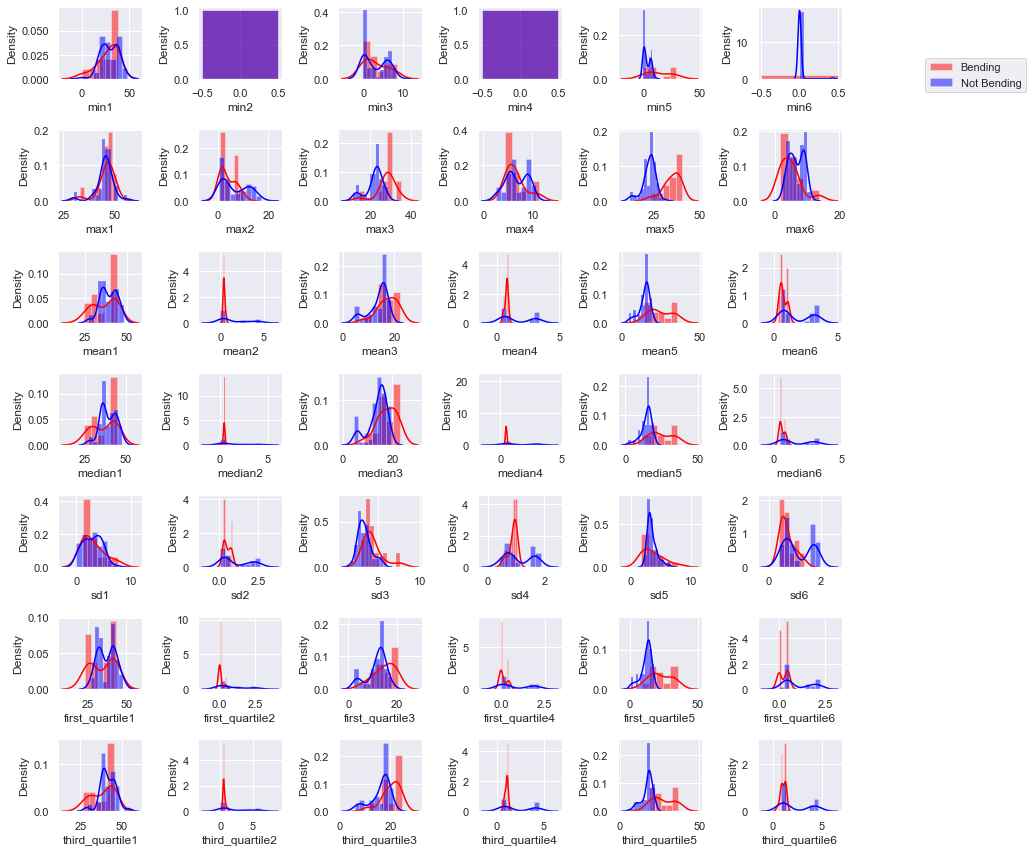

In [1792]:
features = ['min','max','mean','median','sd','first_quartile','third_quartile']
# https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751
# making plot for useful features as suggested on piazza
plt.figure(figsize=(12,12))
for i, ft in enumerate(features, start =1):
    for j in range(1,7):    
        plt.subplot(len(features), 6, 6*i+j-6)
        sns.histplot(bend_train.loc[bend_train['bending']== 1][ft + str(j)] ,
                     kde = True,
                     color="red",
                     stat="density",
                     edgecolor=(1, 1, 1, .4),
                     kde_kws=dict(cut=3),
                     label="Bending")
        sns.histplot(bend_train.loc[bend_train['bending']== 0][ft + str(j)], 
                     kde = True,
                     color="blue", 
                     stat="density",
                     kde_kws=dict(cut=3),
                     edgecolor=(1, 1, 1, .4),
                     label='Not Bending')
print("Different features analysis: ")
plt.tight_layout()
plt.legend(loc=(2,10))
plt.show()

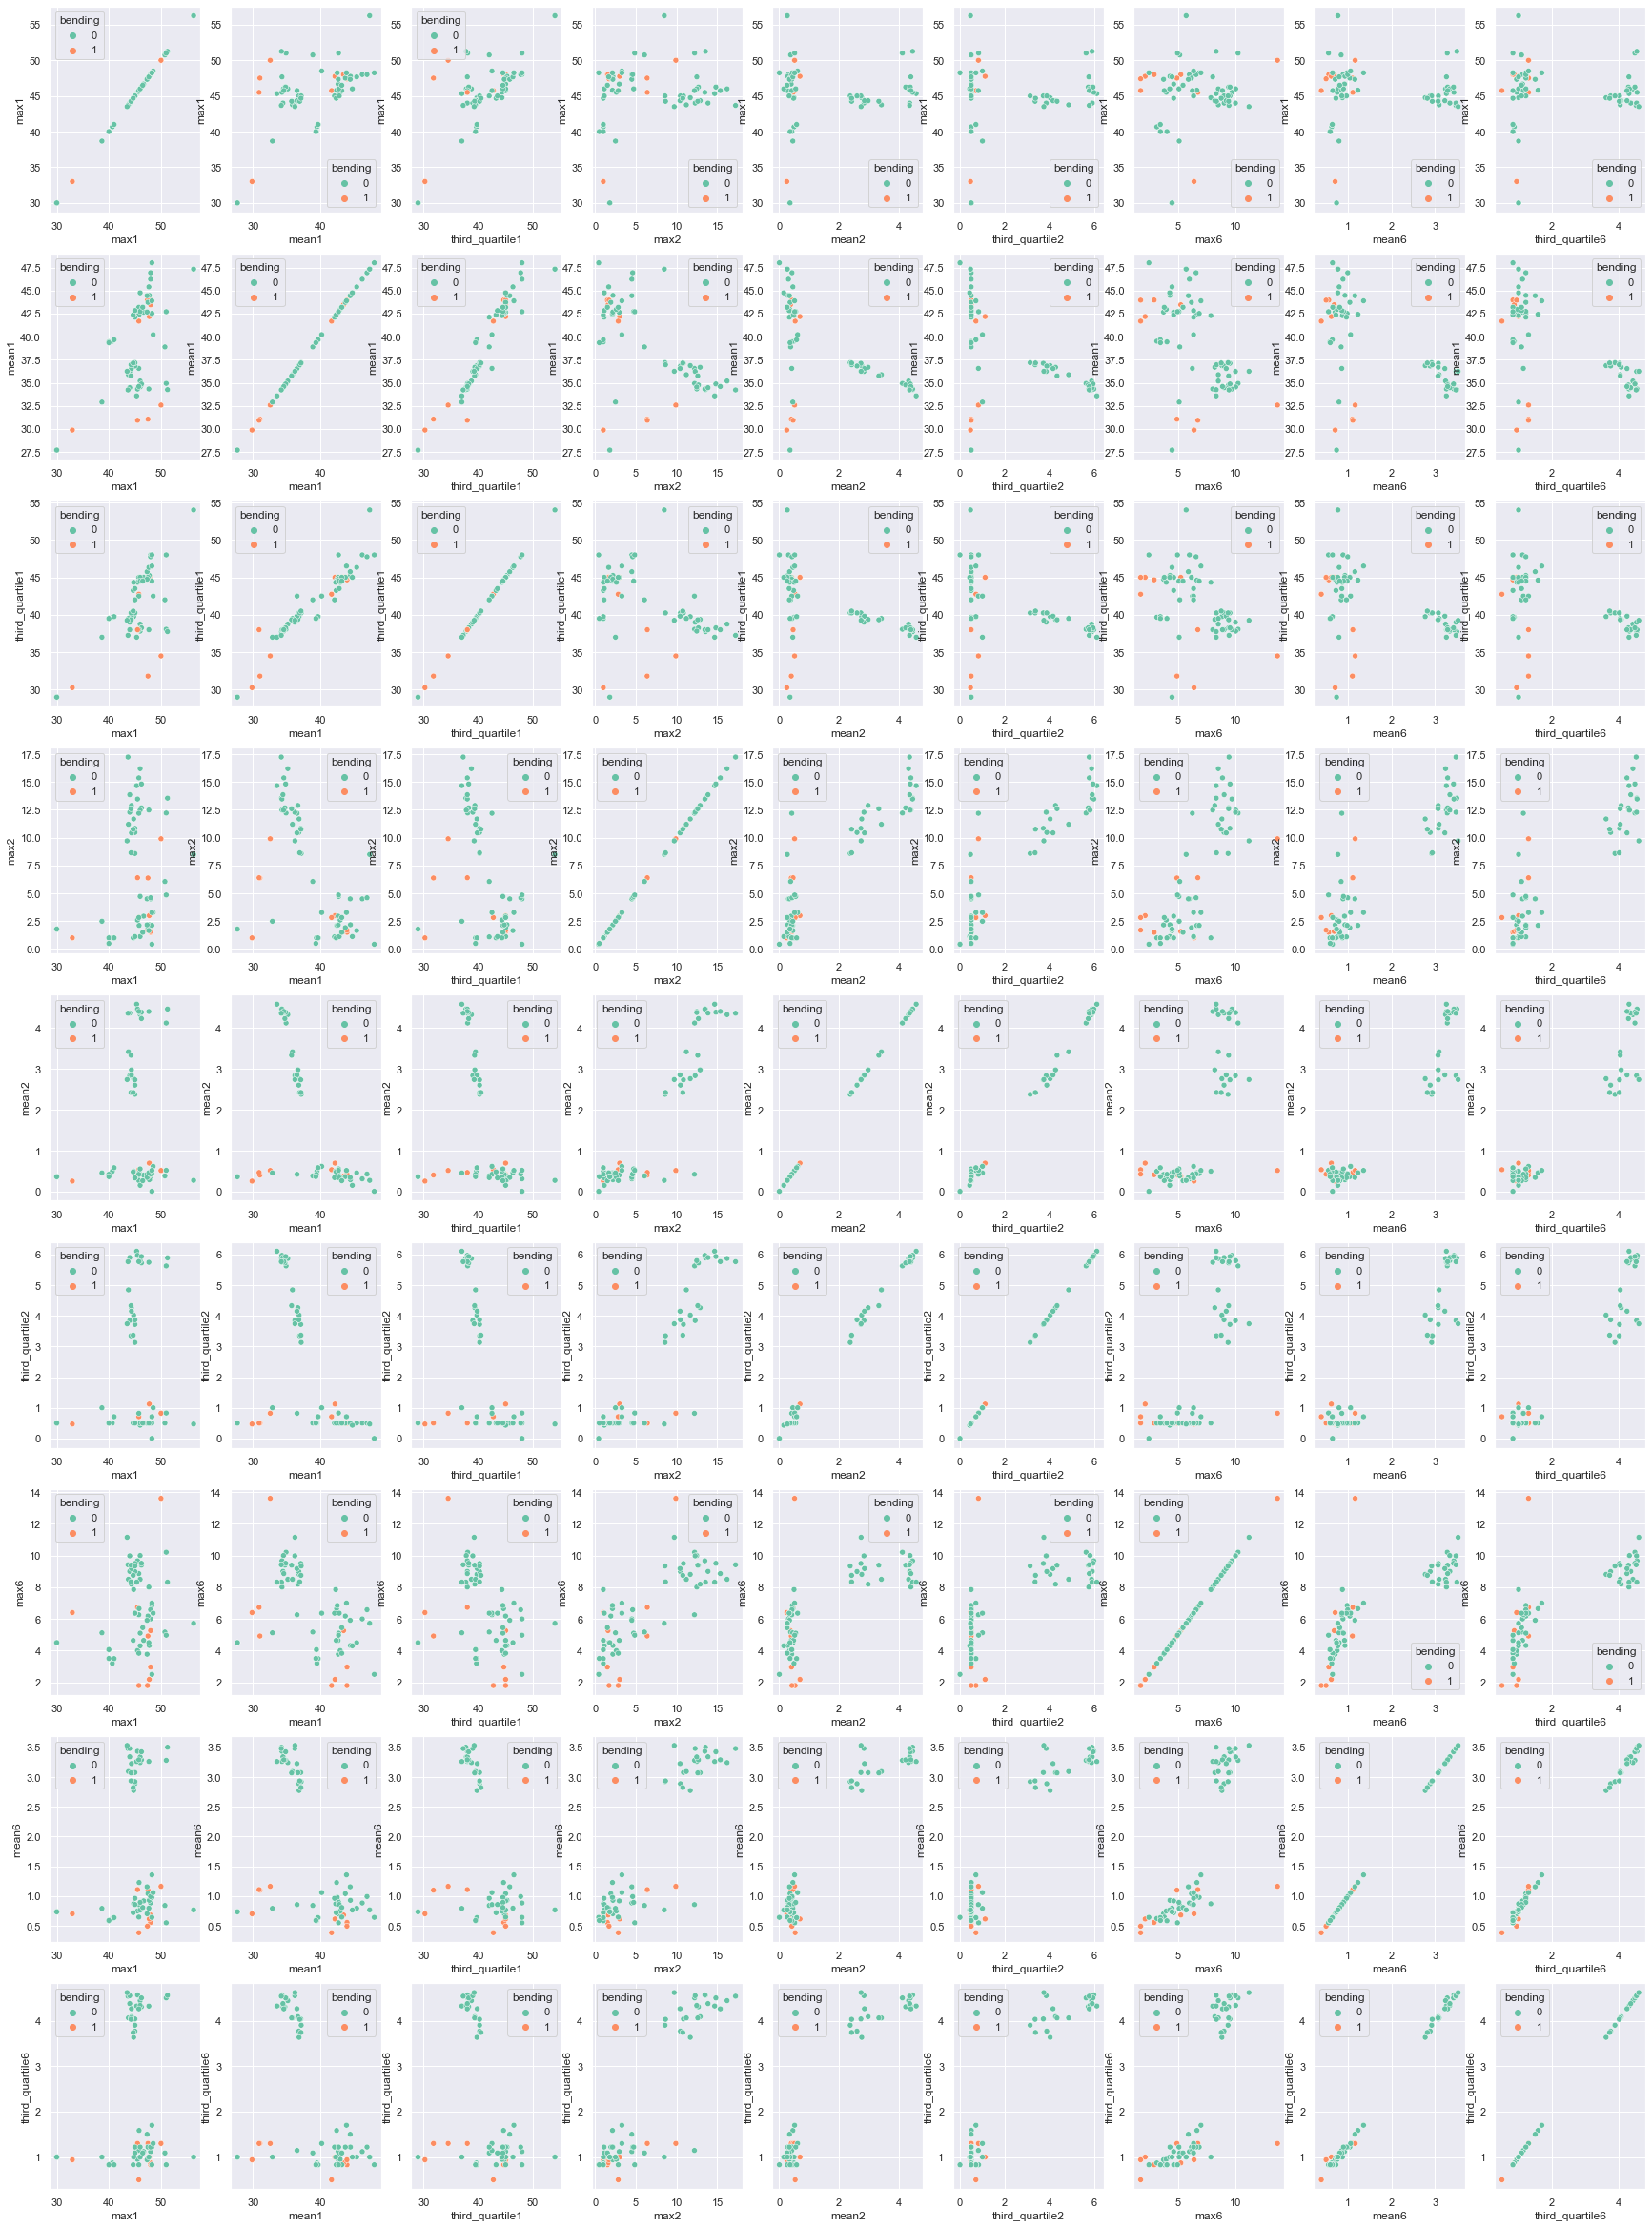

In [1793]:
series = [1,2,6]
stat = ['max','mean','third_quartile']
sel_features = [j+str(i) for i in series for j in stat]
bend_train = new_train_set
bend_train['bending'] = [1 if data.find('bending') != -1 else 0 
                                for data in bend_train['activity'].to_list()]
bend_train = bend_train.drop(['activity'], axis=1)

def plots(data, features, row, col, row_size, col_size):
    if features[-1] != 'bending':
        features.append('bending')
    data = data[features]
    # print(data)
    main=[]
    for i in range(0,len(data.columns)-1):
        for j in range(0,len(data.columns)-1):
            main.append([features[i], features[j]])    
    plt.close()
    fig, axs = plt.subplots(nrows= row, ncols=col, figsize=(row_size,col_size))
    k=0
    for i in range(0,col):
        for j in range(0,row):
            sns.set(font_scale=1)
            plt.subplots_adjust(top=0.92)
            scatter_plot = sns.scatterplot(data=data, x=main[k][0], y=main[k][1], hue="bending", ax=axs[j][i], palette="Set2")
            k+=1  
    plt.show()
plt.title("Scatterplots of mean max & third_quartile (bending) vs other activities", y=11, x = -5)
plots(bend_train, sel_features, 9, 9, 30, 40)

In [1794]:
# with activity
feature_names = ['min','max','mean','median','sd','first_quartile','third_quartile']
all_feat = [j+str(i) for i in range(1,13) for j in feature_names]
all_feat.append('activity')
all_feat_data = load_data(all_set, all_feat, 2)
print(all_feat_data)

# bend train 0 or 1
stat = ['max','mean','third_quartile']
series = [1,2,3,4,11,12]
sel_features2 = [j+str(i) for i in  series for j in stat]
bend_train_data = all_feat_data
bend_train_data['bending'] = [1 if data.find('bending') != -1 else 0 
                                for data in bend_train_data['activity'].to_list()]

bend_train_data = bend_train_data.drop(['activity'], axis=1)
bend_train_data

     min1   max1      mean1  median1       sd1  first_quartile1  \
0   36.67  45.00  43.486208    43.71  1.279302          42.3300   
1   39.00  48.00  44.117042    45.00  1.357000          43.5000   
2   33.75  47.75  43.278875    45.00  3.466111          42.0000   
3   33.00  45.75  41.621208    42.33  3.112140          39.6525   
4   38.00  42.33  40.946958    41.25  1.100662          40.3100   
..    ...    ...        ...      ...       ...              ...   
83  20.00  44.25  35.692167    35.50  4.633910          33.0000   
84  24.25  45.00  36.954208    36.00  3.764968          34.2500   
85  27.00  42.67  36.342750    36.75  3.640886          33.6700   
86  26.25  43.40  36.865417    36.25  3.455571          34.3100   
87  27.75  44.00  37.144583    36.67  3.796850          34.0000   

    third_quartile1   min2   max2      mean2  ...  first_quartile11  \
0             44.50  36.25  48.00  44.452042  ...            0.0000   
1             45.00  37.00  46.50  42.792875  ...    

min1   max1      mean1  median1       sd1  first_quartile1  \
0   36.67  45.00  43.486208    43.71  1.279302          42.3300   
1   39.00  48.00  44.117042    45.00  1.357000          43.5000   
2   33.75  47.75  43.278875    45.00  3.466111          42.0000   
3   33.00  45.75  41.621208    42.33  3.112140          39.6525   
4   38.00  42.33  40.946958    41.25  1.100662          40.3100   
..    ...    ...        ...      ...       ...              ...   
83  20.00  44.25  35.692167    35.50  4.633910          33.0000   
84  24.25  45.00  36.954208    36.00  3.764968          34.2500   
85  27.00  42.67  36.342750    36.75  3.640886          33.6700   
86  26.25  43.40  36.865417    36.25  3.455571          34.3100   
87  27.75  44.00  37.144583    36.67  3.796850          34.0000   

    third_quartile1   min2   max2      mean2  ...  first_quartile11  \
0             44.50  36.25  48.00  44.452042  ...            0.0000   
1             45.00  37.00  46.50  42.792875  ...            0.4300   
2             45.25  33.00  46.00  41.080750  ...            0.0000   
3             44.25  39.25  43.67  41.734917  ...            0.0000   
4             42.00  37.25  45.00  40.302625  ...            0.0000   
..              ...    ...    ...        ...  ...               ...   
83            39.25  18.50  44.00  35.812542  ...            1.7900   
84            40.25  29.00  44.67  37.399875  ...            1.7525   
85            39.00  23.33  43.50  36.145417  ...            2.2525   
86            40.00  29.25  44.25  37.049500  ...            1.6550   
87            40.33  31.00  44.67  37.145083  ...            1.6900   

    third_quartile11  min12  max12    mean12  median12      sd12  \
0             0.8300    0.0   2.96  0.585750      0.50  0.486900   
1             1.1200    0.0   4.06  0.543875      0.50  0.472458   
2             1.2200    0.0   2.18  0.586083      0.47  0.490847   
3             0.7100    0.0   1.50  0.347500      0.43  0.362386   
4             1.3000    0.0   1.92  0.552167      0.43  0.509430   
..               ...    ...    ...       ...       ...       ...   
83            4.3500    0.0   8.81  2.966917      2.59  1.708491   
84            3.9375    0.0   9.34  2.838083      2.45  1.886811   
85            4.7025    0.0  11.15  3.513250      3.08  1.974270   
86            4.0375    0.0   8.34  2.904458      2.57  1.606436   
87            3.9000    0.0   7.93  2.730167      2.55  1.586780   

    first_quartile12  third_quartile12  bending  
0             0.4225            0.8300        1  
1             0.4300            0.7100        1  
2             0.0000            0.8700        1  
3             0.0000            0.5000        1  
4             0.0000            0.9400        1  
..               ...               ...      ...  
83            1.8525            3.7400        0  
84            1.3825            3.8325        0  
85            2.1700            4.5000        0  
86            1.6900            3.7700        0  
87            1.4950            3.7050        0  

[88 rows x 85 columns]

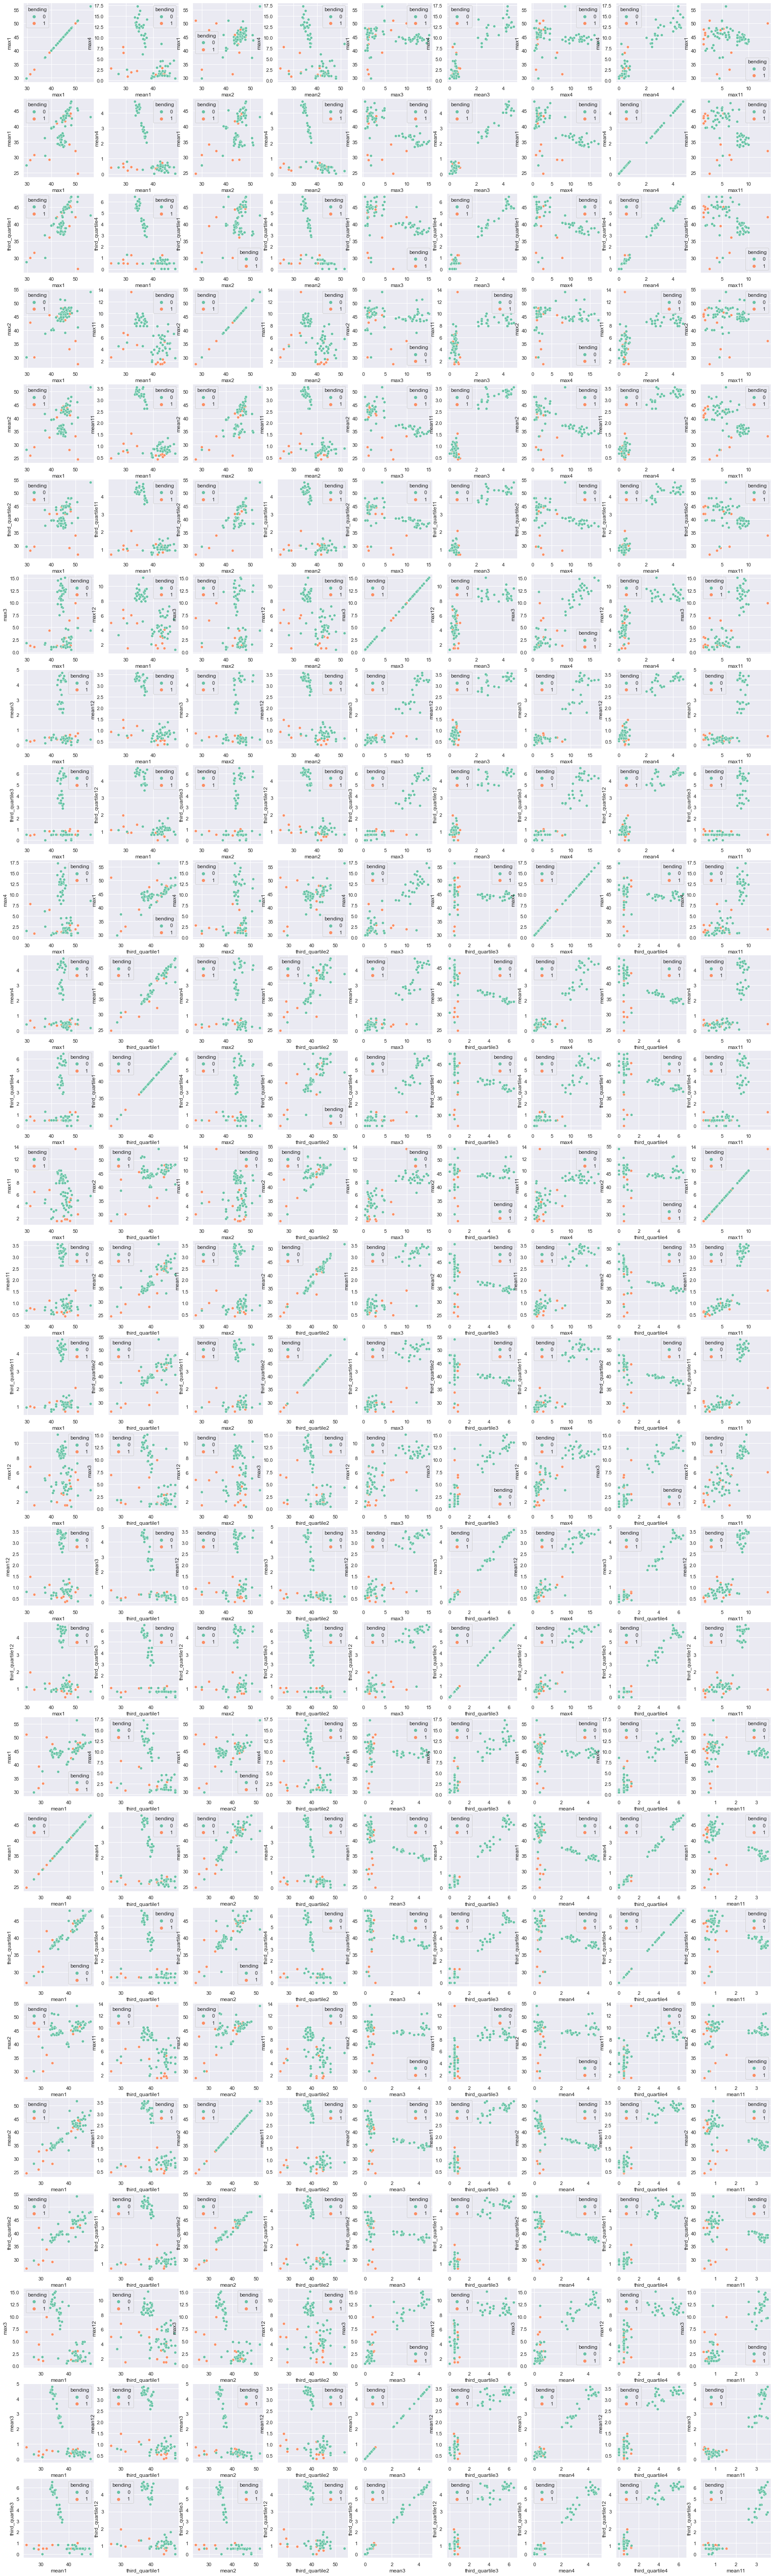

In [1795]:
plt.title("Scatterplots of mean max & third_quartile (bending) vs other activities", y=201, x = -5)
plots(bend_train_data, sel_features2, 27, 9, 30, 100)

#### __iii. Break each time series in your training set into l ∈ {1, 2, . . . , 20} time series of approximately equal length and use logistic regression to solve the binary classification problem, using time-domain features. Remember that breaking each of the time series does not change the number of instances. It only changes the number of features for each instance. Calculate the p-values for your logistic regression parameters in each model corresponding to each value of l and refit a logistic regression model using your pruned set of features. Alternatively, you can use backward selection using sklearn.feature selection or glm in R. Use 5-fold cross-validation to determine the best value of the pair (l, p), where p is the number of features used in recursive feature elimination. Explain what the right way and the wrong way are to perform cross-validation in this problem. Obviously, use the right way! Also, you may encounter the problem of class imbalance, which may make some of your folds not having any instances of the rare class. In such a case, you can use stratified cross validation. Research what it means and use it if needed.__

In [1796]:
# https://pandas.pydata.org/docs/reference/api/pandas.Series.resample.html#pandas.Series.resample
# https://stackoverflow.com/questions/69383018/best-way-to-downsample-reduce-sample-rate-non-time-series-data-in-pandas 
def downsampling(data):
    class1 = data.loc[data['bending'] == 1].shape[0]
    class0 = data.loc[data['bending'] == 0].shape[0]
    min_count = min(class1, class0)
    max_count = max(class1, class0)
    max_bending = 1 if class1 > class0 else 0
        
    # Dividing into minor and major samples
    major_sampling = data.loc[data['bending'] == max_bending]
    minor_sampling = data.loc[data['bending'] != max_bending]
    
    major_sampling = resample(major_sampling, n_samples = min_count * 3, replace=True, random_state=40)
    data = pd.concat([minor_sampling, major_sampling], ignore_index=True)
    return data

# https://pandas.pydata.org/docs/reference/api/pandas.Series.resample.html#pandas.Series.resample
# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegressionCV.html
def logisticRegressionCV(train_files, k, L, downSample=False, penalty='none'):    
    columns = ['# Columns: time','avg_rss12', 'var_rss12','avg_rss13', 'var_rss13','avg_rss23', 'var_rss23']
    all_features = ['min','max','mean','median','sd','first_quartile','third_quartile']
    sel_lcvfeatures = [j+str(i) for i in range(1,6*L+1) for j in all_features]
    sel_lcvfeatures.append('activity')
    training_dataset = load_data(train_files, sel_lcvfeatures, L)
    training_dataset['bending'] = [1 if data.find('bending') != -1 else 0 
                            for data in training_dataset['activity'].to_list()]
    training_dataset = training_dataset.drop(['activity'], axis=1)
    if downSample:
        training_dataset = downsampling(training_dataset)
    my_stats = ['max','mean','third_quartile']
    my_features = [j+str(i) for i in range(1,6*L+1) for j in my_stats]
    my_features.append('bending')
    training_dataset = training_dataset[my_features]
    trainX = training_dataset.iloc[:,:-1]
    trainY = training_dataset.iloc[:,-1]
    # https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html
    stratified_cv = StratifiedKFold(n_splits=k, shuffle=True, random_state=40)
    model = LogisticRegression(penalty=penalty, max_iter=100)
    rfecv = RFECV(estimator=model, cv=StratifiedKFold(n_splits=k, shuffle=True, random_state=40))
    rfecv.fit(trainX, trainY)
    return rfecv, model

In [1797]:
def get_features(res_df, downSample=False):
    l_pair = res_df.loc[res_df['score'] == max(res_df['score'])]
    l_val = l_pair['L'].to_list()[0] # l value
    my_lpair_features = ['max','mean','third_quartile'] # taking the features that i selected 
    # lcv_feat = [j+str(i) for i in range(1,6*lval+1) for j in my_lpair_features]
    lcv_feat = []
    for i in range(1,6*l_val+1):
        for j in my_lpair_features:
            lcv_feat.append(j+str(i))  
    rfecv, model = logisticRegressionCV(train_set, 5, l_val, downSample=downSample)
    selected_features = [f for i, f in enumerate(lcv_feat) if rfecv.support_[i]]
    if downSample:
        feature_names = ['min','max','mean','median','sd','first_quartile','third_quartile']
        features_load = [j+str(i) for i in range(1,6*l_val+1) for j in feature_names]
        features_load.append('activity')
        data_lcv = load_data(train_set, features_load, l_val)
        data_lcv['bending'] = [1 if data.find('bending') != -1 else 0 
                            for data in data_lcv['activity'].to_list()]
        data_lcv = data_lcv.drop(['activity'], axis=1)
        class1 = data_lcv.loc[data_lcv['bending'] == 1].shape[0]
        class0 = data_lcv.loc[data_lcv['bending'] == 0].shape[0]
        pi = class1 / (class1 + class0)
        pi1 = 1 / 4
        rfecv.estimator_.intercept_ += pi/(1-pi) + pi1/(1-pi1)
    return selected_features, l_val, model 

def data_splits(data, l_val, downSample=False):
    feature_names = ['min','max','mean','median','sd','first_quartile','third_quartile']
    features_load = [j+str(i) for i in range(1,6*l_val+1) for j in feature_names]
    features_load.append('activity')
    data_lcv = load_data(data, features_load, l_val)
    data_lcv['bending'] = [1 if data.find('bending') != -1 else 0 
                            for data in data_lcv['activity'].to_list()]
    data_lcv = data_lcv.drop(['activity'], axis=1)
    if downSample:
        data_lcv = downsampling(data_lcv)
    xdata = data_lcv.iloc[:,:-1]
    xdata = xdata[selected_features]
    ydata = data_lcv.iloc[:,-1]
    return xdata, ydata
def conf_matrix(model, xval, yval):
    model.fit(xval, yval)
    ypred = model.predict(xval)
    my_matrix = confusion_matrix(yval, ypred)
    return my_matrix
def roc_auc(xval, yval, model, dtype):
    y_pred_prob = model.predict_proba(xval)    
    fpr, tpr, thresholds = roc_curve(yval, y_pred_prob[:, 1], pos_label=1)
    roc_auc = auc(fpr, tpr)
    plt.close()
    plt.figure(figsize=(10,6))
    plt.title("ROC Curve for"+ dtype +"data")
    plt.plot(fpr, tpr, 'b', label="Area Under Curve(AUC): {}".format(roc_auc))
    plt.plot([0,1], [0,1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    # plt.grid()
    plt.show()

In [1798]:
res_df = pd.DataFrame(columns=['L', 'p','score'])
for i in tqdm(range(1,21)):
    res_up_df=[]
    # n_split = 5
    features_selected, model = logisticRegressionCV(train_set, 5, i)
    res_up_df.extend([i, features_selected.n_features_, max(features_selected.cv_results_["mean_test_score"])])
    df_new = pd.Series(res_up_df, index = ['L', 'p', 'score'])
    res_df = res_df.append(df_new, ignore_index=True)
    res_df['L'] = res_df['L'].astype(int)
    res_df['p'] = res_df['p'].astype(int)
res_df

100%|██████████| 20/20 [02:21<00:00,  7.07s/it]


L   p     score
0    1   4  1.000000
1    2  26  0.971429
2    3   7  1.000000
3    4   2  0.985714
4    5   2  0.985714
5    6   6  0.971429
6    7  10  0.971429
7    8   8  0.971429
8    9  14  0.971429
9   10   3  0.971429
10  11  39  0.985714
11  12  42  0.985714
12  13  35  0.971429
13  14  80  0.985714
14  15  15  0.985714
15  16  62  0.985714
16  17  87  0.985714
17  18  70  0.985714
18  19  92  0.985714
19  20  84  0.971429

### iv. Report the confusion matrix and show the ROC and AUC for your classifier on train data. Report the parameters of your logistic regression βi’s as well as the p-values associated with them.

l features 1 are ['third_quartile1', 'max5', 'mean5', 'max6']
[[60  0]
 [ 0  9]]


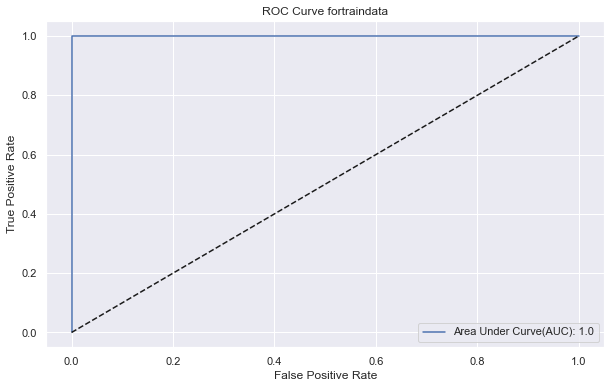

         Current function value: 0.015013
         Iterations: 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                bending   No. Observations:                   69
Model:                          Logit   Df Residuals:                       64
Method:                           MLE   Df Model:                            4
Date:                Thu, 13 Oct 2022   Pseudo R-squ.:                  0.9612
Time:                        22:36:37   Log-Likelihood:                -1.0359
converged:                      False   LL-Null:                       -26.718
Covariance Type:            nonrobust   LLR p-value:                 1.874e-10
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -1.1586     12.041     -0.096      0.923     -24.759      22.442
third_quartile1    -0.6647      0.355     -1.872      0.061      -1.361       0.031
max5                0.5476      0.458      1.195      0.232      -0.351       1.446
mean5               0.7822      0.629      1.243      0.214      -0.451       2.015
max6               -0.5149      0.502     -1.025      0.305      -1.500       0.470
===================================================================================

Possibly complete quasi-separation: A fraction 0.38 of observations can be
perfectly predicted. This might indicate that there is complete
quasi-separation. In this case some parameters will not be identified.
"""

In [1799]:
# Get Selected Features for best 'L'
selected_features, l_val, model = get_features(res_df)
print('l features {} are {}'.format(l_val, selected_features))
# Get xtrain and Train_Y
xtrain, ytrain = data_splits(train_set, l_val)
# Confusion Matrix
my_matrix = conf_matrix(model, xtrain, ytrain)
print(my_matrix)
# ROC- AUC curve
roc_auc(xtrain, ytrain, model, 'train')
train_X_add = sm.add_constant(xtrain)
log_reg = sm.Logit(ytrain, train_X_add).fit(model='bfgs',maxiter=5)
log_reg.summary()

### V. Test the classifier on the test set. Remember to break the time series in your test set into the same number of time series into which you broke your training set. Remember that the classifier has to be tested using the features extracted from the test set. Compare the accuracy on the test set with the cross-validation accuracy you obtained previously.

[[15  0]
 [ 0  4]]


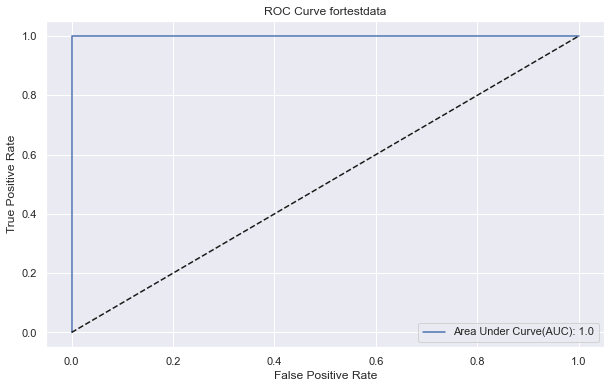

In [1800]:
# Get best 'L'
selected_features, l_val, model = get_features(res_df)
# Get xtest and Test_Y
xtest, ytest = data_splits(test_set, l_val)
# Confusion Matrix
my_matrix = conf_matrix(model, xtest, ytest)
print(my_matrix)
# ROC- AUC curve
roc_auc(xtest, ytest, model, 'test')

### vii. From the confusion matrices you obtained, do you see imbalanced classes? If yes, build a logistic regression model based on case-control sampling and adjust its parameters. Report the confusion matrix, ROC, and AUC of the model.

In [1801]:
res_df = pd.DataFrame(columns=['L', 'p','score'])

for i in tqdm(range(1,21)):
    res_up_df=[]
    features_selected, model = logisticRegressionCV(train_set, 5, i, downSample=True)
    res_up_df.extend([i, features_selected.n_features_, max(features_selected.cv_results_["mean_test_score"])])
    df_new = pd.Series(res_up_df, index = ['L', 'p', 'score'])
    res_df = res_df.append(df_new, ignore_index=True)
    res_df['L'] = res_df['L'].astype(int)
    res_df['p'] = res_df['p'].astype(int)

res_df

100%|██████████| 20/20 [02:02<00:00,  6.12s/it]


L   p  score
0    1   3    1.0
1    2  16    1.0
2    3   6    1.0
3    4  18    1.0
4    5  17    1.0
5    6  21    1.0
6    7  27    1.0
7    8   2    1.0
8    9  17    1.0
9   10  21    1.0
10  11   4    1.0
11  12  10    1.0
12  13  33    1.0
13  14  22    1.0
14  15  28    1.0
15  16   3    1.0
16  17  19    1.0
17  18  20    1.0
18  19  31    1.0
19  20  20    1.0

Features selected for best L - 1 are ['third_quartile1', 'max2', 'max5']
[[27  0]
 [ 0  9]]


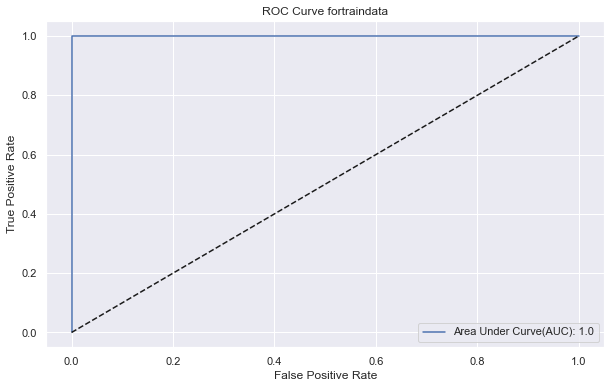

In [1802]:
# Get Selected Features for best 'L'
selected_features, l_val, model = get_features(res_df, downSample=True)
print('Features selected for best L - {} are {}'.format(l_val, selected_features))
# Get xtrain and xtrain
xtrain, ytrain = data_splits(train_set, l_val, downSample=True)
# Confusion Matrix
my_matrix = conf_matrix(model, xtrain, ytrain)
print(my_matrix)
# ROC- AUC curve
roc_auc(xtrain, ytrain, model, 'train')

[[15  0]
 [ 0  4]]


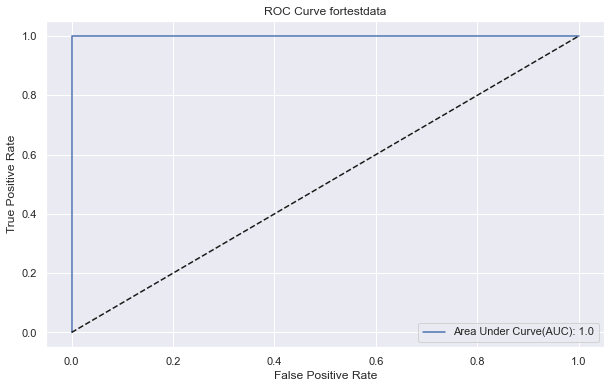

In [1803]:
# Get Test_X and Test_Y
xtest, ytest = data_splits(test_set, l_val)
# Confusion Matrix
my_matrix = conf_matrix(model, xtest, ytest)
print(my_matrix)
# ROC- AUC curve
roc_auc(xtest, ytest, model, 'test')

## (b) Binary Classification Using L1-penalized logistic regression

### i. Repeat 2(a)iii using L1-penalized logistic regression, i.e. instead of using p-values for variable selection, use L1 regularization. Note that in this problem, you have to cross-validate for both l, the number of time series into which you break each of your instances, and λ, the weight of L1 penalty in your logistic regression objective function (or C, the budget). Packages usually perform cross-validation for λ automatically.

In [1808]:
def log_dataset(train_set, test_set, L, class_type, binary_class=True, multi_class='auto'):    
    orig_columns = ['# Columns: time','avg_rss12', 'var_rss12','avg_rss13', 'var_rss13','avg_rss23', 'var_rss23']
    features = ['min','max','mean','median','sd','first_quartile','third_quartile']
    sel_lcvfeatures = [name+str(i) for i in range(1,6*L+1) for name in features]
    sel_lcvfeatures.append('activity')
    
    training_dataset = load_data(train_set, sel_lcvfeatures, L)
    testing_dataset = load_data(test_set, sel_lcvfeatures, L)
    
    if binary_class:
        training_dataset['bending'] = [1 if data.find('bending') != -1 else 0 for data in training_dataset['activity'].to_list()]
        training_dataset = training_dataset.drop(['activity'], axis=1)
        training_dataset.rename(columns={'bending':'activity'}, inplace=True)
        testing_dataset['bending'] = [1 if data.find('bending') != -1 else 0 for data in testing_dataset['activity'].to_list()]
        testing_dataset = testing_dataset.drop(['activity'], axis=1)
        testing_dataset.rename(columns={'bending':'activity'}, inplace=True)
    my_features = ['max','mean','third_quartile']
    my_new_features = [name+str(i) for i in range(1,6*L+1) for name in my_features]
    my_new_features.append('activity')
    
    training_dataset = training_dataset[my_new_features]
    testing_dataset = testing_dataset[my_new_features]
    trainX = training_dataset.iloc[:,:-1]
    trainY = training_dataset.iloc[:,-1]
    testX = testing_dataset.iloc[:,:-1]
    testY = testing_dataset.iloc[:,-1]
    
    if multi_class == 'multinomial':
        solver = 'saga'
    else:
        solver = 'liblinear'
    
    if class_type == 'LogisticRegressionCV':    
        model = LogisticRegressionCV(penalty='l1', solver=solver, multi_class=multi_class, cv=5, random_state=7)
    elif class_type == 'LogisticRegression':
        model = LogisticRegression(penalty='l1', solver=solver, multi_class=multi_class)
    elif class_type == 'GaussianNB':
        model = GaussianNB()
    elif class_type == 'MultinomialNB':
        model = MultinomialNB()
    
    model.fit(trainX, trainY)
    
    trscore = model.score(trainX, trainY)
    ts_score = model.score(testX, testY)

    return model, 1 - trscore, 1 - ts_score

In [1809]:
def log_cv_split(l_val, class_type, binary_class=True):
    feature_names = ['min','max','mean','median','sd','first_quartile','third_quartile']
    features_load = [name+str(i) for i in range(1,6*l_val+1) for name in feature_names]
    features_load.append('activity')
    
    training_dataset = load_data(train_set, features_load, l_val)
    testing_dataset = load_data(test_set, features_load, l_val)
    
    if binary_class:
        training_dataset['bending'] = [1 if data.find('bending') != -1 else 0 
                                for data in training_dataset['activity'].to_list()]
        training_dataset = training_dataset.drop(['activity'], axis=1)
        
        training_dataset.rename(columns={'bending':'activity'}, inplace=True)
        
        testing_dataset['bending'] = [1 if data.find('bending') != -1 else 0 
                                for data in testing_dataset['activity'].to_list()]
        testing_dataset = testing_dataset.drop(['activity'], axis=1)
        
        testing_dataset.rename(columns={'bending':'activity'}, inplace=True)
    
    my_features = ['max','mean','third_quartile']
    my_new_features = [name+str(i) for i in range(1,6*l_val+1) for name in my_features]
    my_new_features.append('activity')
    
    training_dataset = training_dataset[my_new_features]
    testing_dataset = testing_dataset[my_new_features]
    
    xtrain = training_dataset.iloc[:,:-1]
    ytrain = training_dataset.iloc[:,-1]
    xtest = testing_dataset.iloc[:,:-1]
    ytest = testing_dataset.iloc[:,-1]
    
    if binary_class and class_type == 'LogisticRegression':
        model, training_err, testing_err = log_dataset(train_set, test_set, l_val, 'LogisticRegression')
    elif binary_class == False and class_type == 'LogisticRegression':
        model, training_err, testing_err = log_dataset(train_set, test_set, l_val, 'LogisticRegression', 
                                                       binary_class=False, multi_class='multinomial')
    elif binary_class == False and class_type == 'GaussianNB':
        model, training_err, testing_err = log_dataset(train_set, test_set, l_val, 'GaussianNB', binary_class=False)
    elif binary_class == False and class_type == 'MultinomialNB':
        model, training_err, testing_err = log_dataset(train_set, test_set, l_val, 'MultinomialNB', binary_class=False)    
    return xtrain, ytrain, xtest, ytest, model

In [1810]:
res_df = pd.DataFrame(columns=['L', 'training_err','testing_err'])

for i in tqdm(range(1,21)):
    res_up_df=[]
    model, training_err, testing_err = log_dataset(train_set, test_set, i, 'LogisticRegressionCV')
    res_up_df.extend([i, training_err, testing_err])
    df_new = pd.Series(res_up_df, index = ['L', 'training_err', 'testing_err'])
    res_df = res_df.append(df_new, ignore_index=True)
    res_df['L'] = res_df['L'].astype(int)

res_df

100%|██████████| 20/20 [01:16<00:00,  3.81s/it]


L  training_err  testing_err
0    1      0.000000     0.000000
1    2      0.043478     0.052632
2    3      0.000000     0.000000
3    4      0.000000     0.052632
4    5      0.000000     0.052632
5    6      0.000000     0.000000
6    7      0.000000     0.052632
7    8      0.000000     0.052632
8    9      0.000000     0.000000
9   10      0.000000     0.052632
10  11      0.000000     0.052632
11  12      0.028986     0.052632
12  13      0.028986     0.052632
13  14      0.028986     0.052632
14  15      0.000000     0.052632
15  16      0.028986     0.052632
16  17      0.014493     0.052632
17  18      0.014493     0.052632
18  19      0.014493     0.052632
19  20      0.000000     0.052632

[[60  0]
 [ 0  9]]


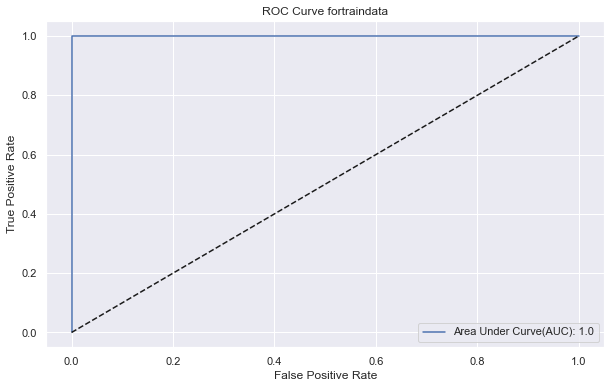

In [1811]:
# Best L
lp_score = res_df.loc[res_df['testing_err'] == min(res_df['testing_err'])]
l_val = lp_score['L'].to_list()[0]
xtrain, ytrain, xtest, ytest, model = log_cv_split(l_val, 'LogisticRegression')
# Confusion Matrix
my_matrix = conf_matrix(model, xtrain, ytrain)
print(my_matrix)
# ROC- AUC curve
roc_auc(xtrain, ytrain, model, 'train')


[[15  0]
 [ 0  4]]


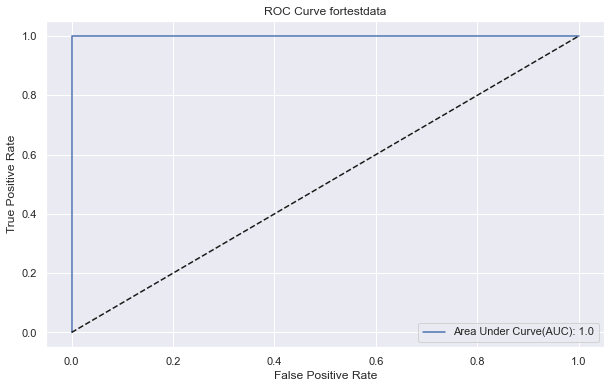

In [1812]:
# Confusion Matrix
my_matrix = conf_matrix(model, xtest, ytest)
print(my_matrix)
# ROC- AUC curve
roc_auc(xtest, ytest, model, 'test')

## (c) Multi-class Classification (The Realistic Case)

### i. Find the best l in the same way as you found it in 2(b)i to build an L1- penalized multinomial regression model to classify all activities in your training set. Report your test error. Research how confusion matrices and ROC curves are defined for multiclass classification and show them for this problem if possible.

In [1813]:
def roc_auc_updated(data_X, data_Y, model, data_type):
    #ROC and AUC
    predict_Y_prob_estimates = model.predict_proba(data_X)
    
    plt.close()
    plt.figure(figsize=(10,6))
    
    for idx, activity in enumerate(model.classes_):
        fpr, tpr, thresholds = roc_curve(data_Y, predict_Y_prob_estimates[:, idx], pos_label=activity)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label="AUC {} : {}".format(activity, roc_auc))
    
    plt.plot([0,1], [0,1], 'k--')

    plt.title('ROC Curve for {} data'.format(data_type))
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

    plt.legend()
    plt.grid()
    plt.show()

In [1814]:
res_df = pd.DataFrame(columns=['L', 'training_err','testing_err'])

for i in tqdm(range(1, 21)):
    res_up_df=[]
    model, training_err, testing_err = log_dataset(train_set, test_set, i, 'LogisticRegressionCV', 
                                                      binary_class=False, multi_class='multinomial')
    res_up_df.extend([i, training_err, testing_err])
    df_new = pd.Series(res_up_df, index = ['L', 'training_err', 'testing_err'])
    res_df = res_df.append(df_new, ignore_index=True)
    res_df['L'] = res_df['L'].astype(int)

res_df

100%|██████████| 20/20 [01:40<00:00,  5.04s/it]


L  training_err  testing_err
0    1      0.028986     0.052632
1    2      0.000000     0.105263
2    3      0.000000     0.157895
3    4      0.028986     0.105263
4    5      0.000000     0.105263
5    6      0.000000     0.210526
6    7      0.000000     0.157895
7    8      0.000000     0.210526
8    9      0.000000     0.157895
9   10      0.000000     0.157895
10  11      0.000000     0.210526
11  12      0.000000     0.210526
12  13      0.000000     0.210526
13  14      0.000000     0.210526
14  15      0.000000     0.210526
15  16      0.000000     0.210526
16  17      0.000000     0.210526
17  18      0.000000     0.263158
18  19      0.014493     0.157895
19  20      0.014493     0.210526

[[ 4  0  0  0  1  0  0]
 [ 1  3  0  0  0  0  0]
 [ 0  0 12  0  0  0  0]
 [ 0  0  0 12  0  0  0]
 [ 0  0  0  0 11  1  0]
 [ 0  0  0  0  1 11  0]
 [ 0  0  0  0  0  0 12]]


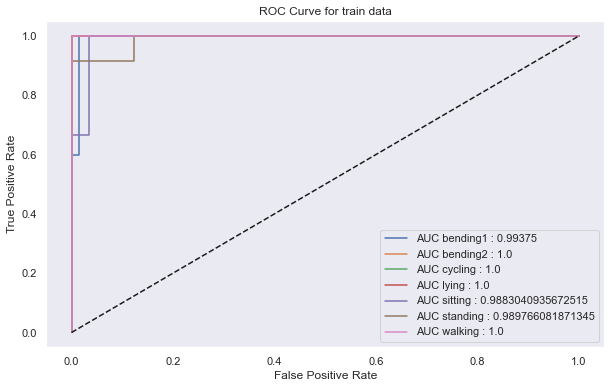

In [1816]:
# Best L
lp_score = res_df.loc[res_df['testing_err'] == min(res_df['testing_err'])]
l_val = lp_score['L'].to_list()[0]
xtrain, ytrain, xtest, ytest, model = log_cv_split(l_val, 'LogisticRegression', binary_class=False)
# Confusion Matrix
my_matrix = conf_matrix(model, xtrain, ytrain)
print(my_matrix)
# ROC_AUC Curve 
roc_auc_updated(xtrain, ytrain, model, 'train')

[[2 0 0 0 0 0 0]
 [0 2 0 0 0 0 0]
 [0 0 3 0 0 0 0]
 [0 0 0 3 0 0 0]
 [0 0 0 0 3 0 0]
 [0 0 0 0 0 3 0]
 [0 0 0 0 0 0 3]]


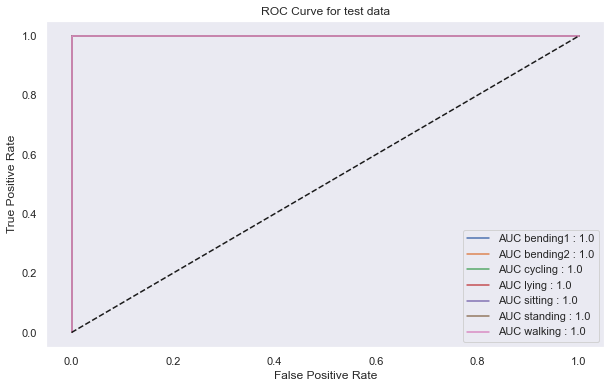

In [1817]:
# Confusion Matrix
my_matrix = conf_matrix(model, xtest, ytest)
print(my_matrix)
# ROC_AUC Curve 
roc_auc_updated(xtest, ytest, model, 'test')

### ii. Repeat 2(c)i using a Naive Bayes’ classifier. Use both Gaussian and Multinomial priors and compare the results.

### Gaussian Naive Bayes

In [1818]:
nb_result = pd.DataFrame(columns=['L', 'training_err','testing_err'])

for i in tqdm(range(1, 21)):
    res_up_df=[]
    nb_model, training_err, testing_err = log_dataset(train_set, test_set, i, 'GaussianNB', binary_class=False)
    res_up_df.extend([i, training_err, testing_err])
    df_new = pd.Series(res_up_df, index = ['L', 'training_err', 'testing_err'])
    nb_result = nb_result.append(df_new, ignore_index=True)
    nb_result['L'] = nb_result['L'].astype(int)

nb_result


100%|██████████| 20/20 [01:14<00:00,  3.74s/it]


L  training_err  testing_err
0    1      0.057971     0.000000
1    2      0.014493     0.052632
2    3      0.014493     0.105263
3    4      0.014493     0.105263
4    5      0.014493     0.105263
5    6      0.014493     0.157895
6    7      0.000000     0.157895
7    8      0.014493     0.105263
8    9      0.000000     0.157895
9   10      0.000000     0.157895
10  11      0.000000     0.157895
11  12      0.000000     0.157895
12  13      0.014493     0.157895
13  14      0.000000     0.157895
14  15      0.000000     0.210526
15  16      0.000000     0.157895
16  17      0.000000     0.157895
17  18      0.000000     0.157895
18  19      0.000000     0.157895
19  20      0.000000     0.157895

[[ 5  0  0  0  0  0  0]
 [ 0  3  0  1  0  0  0]
 [ 0  0 12  0  0  0  0]
 [ 0  0  0 12  0  0  0]
 [ 1  0  0  0  9  2  0]
 [ 0  0  0  0  0 12  0]
 [ 0  0  0  0  0  0 12]]


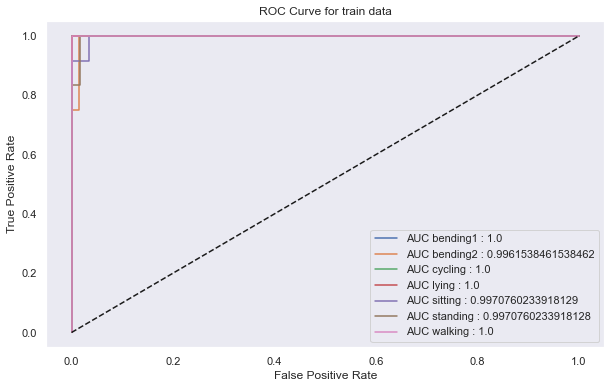

In [1819]:
# Best L
lp_score = nb_result.loc[nb_result['testing_err'] == min(nb_result['testing_err'])]
l_val = lp_score['L'].to_list()[0]
xtrain, ytrain, xtest, ytest, model = log_cv_split(l_val, 'GaussianNB', binary_class=False)
# Confusion Matrix
my_matrix = conf_matrix(model, xtrain, ytrain)
print(my_matrix)
# ROC_AUC Curve 
roc_auc_updated(xtrain, ytrain, model, 'train')

[[2 0 0 0 0 0 0]
 [0 2 0 0 0 0 0]
 [0 0 3 0 0 0 0]
 [0 0 0 3 0 0 0]
 [0 0 0 0 3 0 0]
 [0 0 0 0 0 3 0]
 [0 0 0 0 0 0 3]]


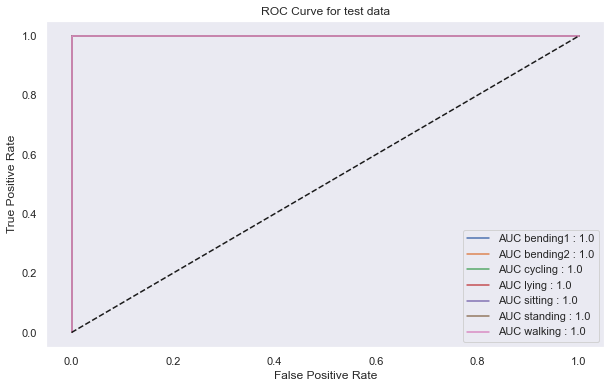

In [1820]:
# Confusion Matrix
my_matrix = conf_matrix(model, xtest, ytest)
print(my_matrix)
# ROC_AUC Curve 
roc_auc_updated(xtest, ytest, model, 'test')

### Multinomial Naive Bayes

In [1821]:
nb_result = pd.DataFrame(columns=['L', 'training_err','testing_err'])

for i in tqdm(range(1, 21)):
    res_up_df=[]
    nb_model, training_err, testing_err = log_dataset(train_set, test_set, i, 'MultinomialNB', binary_class=False)
    res_up_df.extend([i, training_err, testing_err])
    df_new = pd.Series(res_up_df, index = ['L', 'training_err', 'testing_err'])
    nb_result = nb_result.append(df_new, ignore_index=True)
    nb_result['L'] = nb_result['L'].astype(int)

nb_result

100%|██████████| 20/20 [01:15<00:00,  3.76s/it]


L  training_err  testing_err
0    1      0.101449     0.052632
1    2      0.086957     0.105263
2    3      0.057971     0.105263
3    4      0.028986     0.052632
4    5      0.043478     0.052632
5    6      0.028986     0.052632
6    7      0.028986     0.052632
7    8      0.043478     0.105263
8    9      0.043478     0.105263
9   10      0.043478     0.105263
10  11      0.057971     0.105263
11  12      0.043478     0.105263
12  13      0.057971     0.105263
13  14      0.043478     0.105263
14  15      0.057971     0.105263
15  16      0.057971     0.105263
16  17      0.057971     0.105263
17  18      0.057971     0.157895
18  19      0.057971     0.105263
19  20      0.057971     0.105263

[[ 4  0  0  0  1  0  0]
 [ 0  3  0  0  1  0  0]
 [ 0  0 12  0  0  0  0]
 [ 0  0  0 10  2  0  0]
 [ 0  1  0  0 10  1  0]
 [ 0  0  0  0  1 11  0]
 [ 0  0  0  0  0  0 12]]


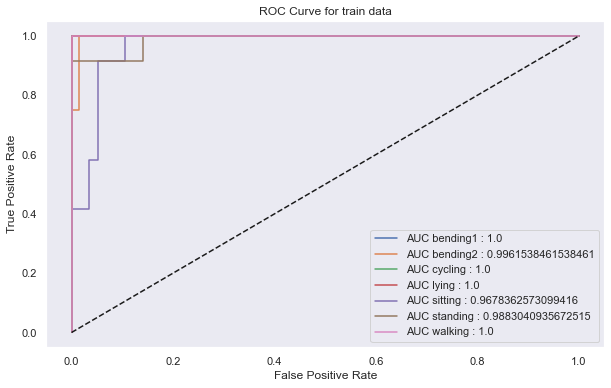

In [1822]:
# Best L
lp_score = nb_result.loc[nb_result['testing_err'] == min(nb_result['testing_err'])]
l_val = lp_score['L'].to_list()[0]
xtrain, ytrain, xtest, ytest, model = log_cv_split(l_val, 'MultinomialNB', binary_class=False)
# Confusion Matrix
my_matrix = conf_matrix(model, xtrain, ytrain)
print(my_matrix)
# ROC_AUC Curve 
roc_auc_updated(xtrain, ytrain, model, 'train')

[[2 0 0 0 0 0 0]
 [0 2 0 0 0 0 0]
 [0 0 3 0 0 0 0]
 [0 0 0 2 0 1 0]
 [0 0 0 0 3 0 0]
 [0 0 0 0 0 3 0]
 [0 0 0 0 0 0 3]]


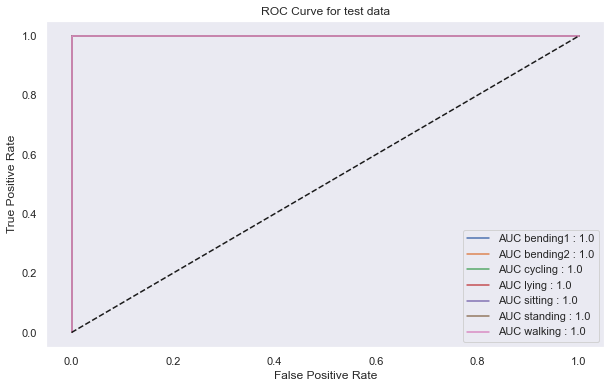

In [1823]:
# Confusion Matrix
my_matrix = conf_matrix(model, xtest, ytest)
print(my_matrix)
# ROC_AUC Curve 
roc_auc_updated(xtest, ytest, model, 'test')

### iii. Which method is better for multi-class classification in this problem?